Hello Enrique!

I’m happy to review your project today.
I will mark your mistakes and give you some hints how it is possible to fix them. We are getting ready for real job, where your team leader/senior colleague will do exactly the same. Don't worry and study with pleasure! 

Below you will find my comments - **please do not move, modify or delete them**.

You can find my comments in green, yellow or red boxes like this:

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Success. Everything is done succesfully.
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Remarks. Some recommendations.
</div>

<div class="alert alert-block alert-danger">

<b>Reviewer's comment</b> <a class="tocSkip"></a>

Needs fixing. The block requires some corrections. Work can't be accepted with the red comments.
</div>

You can answer me by using this:

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Thank you so much for the feedback, I appreacaite it! I should have double checked before submitting. Thanks! 
</div>


# Interconnect EDA and Model Creation: Solution Code

## Initialization

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

## Data Preprocessing

In [2]:
#Merging all dataframes into one

full_data = contract.merge(personal, on='customerID', how='left')\
             .merge(internet, on='customerID', how='left')\
             .merge(phone, on='customerID', how='left')
display(full_data.info())
full_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [3]:
#Convert date columns to datetime
full_data['BeginDate']= pd.to_datetime(full_data['BeginDate'])

#Total charges should also be float type
full_data['TotalCharges'] = pd.to_numeric(full_data['TotalCharges'], errors='coerce')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

The 'EndDate' column contains string and also is our target for this task, so in this case we will leave the column unedited.

__We will now determine how to fill the NaNs that have arisen from the merge.__

Fiber optic    0.561175
DSL            0.438825
Name: InternetService, dtype: float64

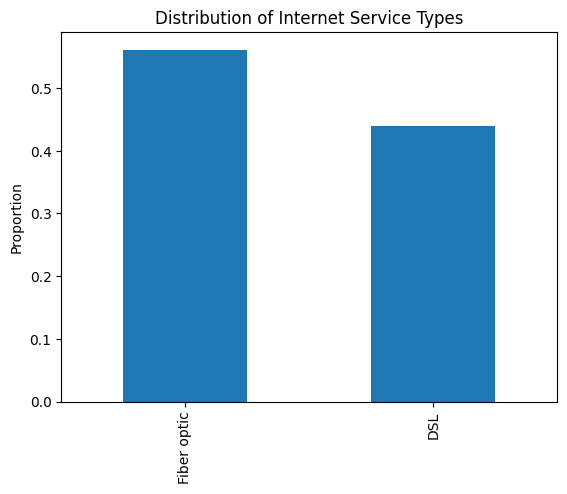

In [4]:
display(full_data['InternetService'].value_counts(normalize=True))
full_data['InternetService'].value_counts(normalize=True).plot(kind = 'bar')
plt.title('Distribution of Internet Service Types')
plt.ylabel('Proportion')
plt.show()

In [5]:
#Fill based on distribution

def fill_proportional(data, columns):
    np.random.seed(999)
    
    for col in columns:
        # Get and display original distribution
        print(f"\nDistribution for {col} before filling:")
        print(data[col].value_counts(normalize=True))
        
        # Fill values proportionally
        value_counts = data[col].value_counts(normalize=True)
        data[col] = data[col].fillna(
            pd.np.random.choice(
                a=list(value_counts.index),
                p=list(value_counts),
                size=1
            )[0]
        )
        
        # Display new distribution
        print(f"\nDistribution for {col} after filling:")
        print(data[col].value_counts(normalize=True))
        print("-" * 50)
    
    return data

# Use the function with your columns
columns_to_fill = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 
                   'StreamingMovies', 'MultipleLines']

full_data = fill_proportional(full_data, columns_to_fill)


Distribution for InternetService before filling:
Fiber optic    0.561175
DSL            0.438825
Name: InternetService, dtype: float64

Distribution for InternetService after filling:
DSL            0.560415
Fiber optic    0.439585
Name: InternetService, dtype: float64
--------------------------------------------------

Distribution for OnlineSecurity before filling:
No     0.63404
Yes    0.36596
Name: OnlineSecurity, dtype: float64

Distribution for OnlineSecurity after filling:
No     0.713332
Yes    0.286668
Name: OnlineSecurity, dtype: float64
--------------------------------------------------

Distribution for OnlineBackup before filling:
No     0.559724
Yes    0.440276
Name: OnlineBackup, dtype: float64

Distribution for OnlineBackup after filling:
No     0.655119
Yes    0.344881
Name: OnlineBackup, dtype: float64
--------------------------------------------------

Distribution for DeviceProtection before filling:
No     0.560993
Yes    0.439007
Name: DeviceProtection, dtype: fl

It makes no sense to use median here, and using mode will create further imbalance. Filling based on the distribution gives us a truer representation of our data instead of using mode.

In [6]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

In [7]:
#Safely remove the 11 missing values
full_data = full_data.dropna()
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  InternetService   7032 non-null   object        
 13  OnlineSecurity    7032 non-null   object        
 14  OnlineBackup      7032 n

All of our NaNs have been filled!

__Let's engineer new features from the 'BeginDate' column.__

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,BeginMonth,BeginYear
5904,9402-CXWPL,2014-04-01,No,One year,No,Electronic check,98.90,6838.60,Female,0,...,Fiber optic,No,Yes,No,No,Yes,Yes,Yes,4,2014
3341,1125-SNVCK,2016-01-01,No,Month-to-month,No,Mailed check,43.80,2106.05,Female,1,...,DSL,No,No,No,No,No,No,No,1,2016
5442,2481-SBOYW,2015-01-01,No,Two year,Yes,Credit card (automatic),25.00,1498.35,Female,0,...,DSL,No,No,Yes,No,No,No,Yes,1,2015
2011,1492-QGCLU,2015-09-01,No,Month-to-month,No,Electronic check,85.70,4616.10,Male,0,...,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,9,2015
4700,5365-LLFYV,2019-12-01,No,Month-to-month,Yes,Mailed check,45.85,105.60,Female,0,...,DSL,No,No,No,No,No,No,No,12,2019
2000,7020-OZKXZ,2019-05-01,No,Month-to-month,No,Credit card (automatic),75.50,637.40,Female,1,...,Fiber optic,No,No,Yes,No,No,No,No,5,2019
5696,0156-FVPTA,2018-01-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,54.20,1152.70,Male,0,...,DSL,Yes,No,No,Yes,No,No,No,1,2018
1872,9938-PRCVK,2016-09-01,No,Two year,No,Bank transfer (automatic),19.70,804.25,Female,0,...,DSL,No,No,Yes,No,No,No,No,9,2016
1585,4522-XRWWI,2016-08-01,No,One year,No,Credit card (automatic),80.45,3375.90,Male,0,...,DSL,Yes,No,No,Yes,Yes,Yes,Yes,8,2016
2970,2815-CPTUL,2019-07-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,70.25,331.90,Male,1,...,Fiber optic,No,No,No,No,No,No,No,7,2019


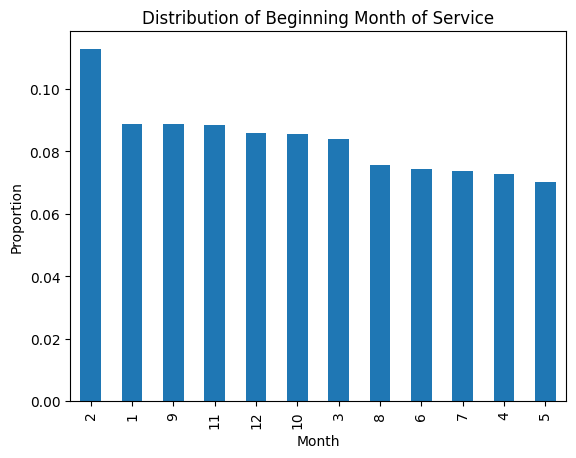

In [8]:
# Extract month and year into new columns
full_data['BeginMonth'] = full_data['BeginDate'].dt.month
full_data['BeginYear'] = full_data['BeginDate'].dt.year
display(full_data.sample(10))
full_data['BeginMonth'].value_counts(normalize=True).plot(kind = 'bar')
plt.title('Distribution of Beginning Month of Service')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.show()

The 'BeginDate' and 'customerID' column won't help us in model creation, so it is best to drop it.

In [9]:
full_data = full_data.drop(['BeginDate', 'customerID'], axis=1)
full_data.head()

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,BeginMonth,BeginYear
0,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Yes,1,2020
1,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,4,2017
2,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,10,2019
3,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Yes,5,2016
4,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,9,2019


## One-Hot Encoding and Scaling

In [10]:
# OHE all of the categorical columns
categorical_columns = [col for col in full_data.select_dtypes(include=['object']).columns if col != 'EndDate']

# Create one-hot encoded features
full_data = pd.get_dummies(full_data, columns=categorical_columns, drop_first=True)
display(full_data.sample(10))
full_data.info()

,EndDate,MonthlyCharges,TotalCharges,SeniorCitizen,BeginMonth,BeginYear,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
1426,No,92.00,6585.20,1,3,2014,1,0,1,0,...,1,0,1,1,1,1,1,0,0,1
4182,2020-01-01 00:00:00,98.65,2862.75,1,8,2017,0,0,0,0,...,0,0,1,0,0,0,1,1,1,1
6996,2019-10-01 00:00:00,66.50,2728.60,0,5,2016,1,0,1,0,...,1,1,0,0,1,0,1,0,1,0
2062,No,25.15,1683.60,0,8,2014,0,1,1,1,...,0,0,0,0,0,1,0,0,0,1
1728,No,81.65,3618.70,0,5,2016,0,1,0,0,...,0,0,0,1,0,1,1,1,1,0
6692,No,74.65,3090.65,0,9,2016,0,0,1,0,...,0,0,0,1,0,1,1,0,1,1
301,2019-10-01 00:00:00,95.45,396.10,1,6,2019,0,0,1,0,...,0,0,1,0,0,0,0,1,1,1
2397,2019-12-01 00:00:00,88.35,88.35,0,11,2019,0,0,1,0,...,0,0,1,0,0,0,0,1,1,0
5697,2019-12-01 00:00:00,109.50,7674.55,0,2,2014,1,0,1,0,...,1,0,1,0,1,1,1,1,1,1
2032,2019-11-01 00:00:00,88.15,1390.60,0,8,2018,0,0,0,0,...,1,0,1,0,0,0,0,1,1,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   EndDate                                7032 non-null   object 
 1   MonthlyCharges                         7032 non-null   float64
 2   TotalCharges                           7032 non-null   float64
 3   SeniorCitizen                          7032 non-null   int64  
 4   BeginMonth                             7032 non-null   int64  
 5   BeginYear                              7032 non-null   int64  
 6   Type_One year                          7032 non-null   uint8  
 7   Type_Two year                          7032 non-null   uint8  
 8   PaperlessBilling_Yes                   7032 non-null   uint8  
 9   PaymentMethod_Credit card (automatic)  7032 non-null   uint8  
 10  PaymentMethod_Electronic check         7032 non-null   uint8  
 11  Paym

In [11]:
# Select numerical columns excluding target
numeric_columns = [col for col in full_data.select_dtypes(include=['int64', 'float64', 'uint8']).columns if col not in ['EndDate', 'BeginMonth', 'BeginYear']]

# Initialize scaler
scaler = StandardScaler()

# Scale numeric columns
full_data[numeric_columns] = scaler.fit_transform(full_data[numeric_columns])
full_data.sample(10)

,EndDate,MonthlyCharges,TotalCharges,SeniorCitizen,BeginMonth,BeginYear,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
3006,2020-01-01 00:00:00,0.337450,-0.549962,2.271039,11,2018,-0.514537,-0.561364,0.828939,-0.525351,...,-0.965608,-0.652305,1.127527,-0.633746,-0.725516,-1.128178,-0.639260,-0.790186,-0.796849,0.963411
3839,No,-1.487450,-0.881934,-0.440327,11,2018,-0.514537,-0.561364,-1.206361,-0.525351,...,1.035617,1.533025,-0.886896,-0.633746,-0.725516,0.886385,-0.639260,-0.790186,-0.796849,-1.037979
3560,No,-0.694666,-0.884537,-0.440327,7,2019,-0.514537,-0.561364,-1.206361,-0.525351,...,-0.965608,-0.652305,-0.886896,-0.633746,-0.725516,-1.128178,-0.639260,-0.790186,-0.796849,-1.037979
843,No,-1.128453,-0.833492,-0.440327,1,2019,-0.514537,-0.561364,0.828939,-0.525351,...,-0.965608,-0.652305,-0.886896,1.577918,-0.725516,-1.128178,-0.639260,-0.790186,-0.796849,0.963411
5562,No,0.400607,0.879044,2.271039,6,2015,-0.514537,-0.561364,0.828939,-0.525351,...,1.035617,-0.652305,1.127527,-0.633746,-0.725516,-1.128178,1.564308,-0.790186,-0.796849,0.963411
5187,No,1.316381,0.816483,2.271039,9,2016,-0.514537,-0.561364,0.828939,-0.525351,...,-0.965608,-0.652305,1.127527,-0.633746,1.378330,0.886385,-0.639260,1.265525,1.254943,0.963411
3645,No,-1.520691,-0.937810,-0.440327,5,2019,-0.514537,-0.561364,-1.206361,-0.525351,...,-0.965608,-0.652305,-0.886896,-0.633746,-0.725516,0.886385,-0.639260,-0.790186,-0.796849,-1.037979
3638,2019-10-01 00:00:00,-0.486913,-0.956583,2.271039,8,2019,-0.514537,-0.561364,-1.206361,1.903490,...,1.035617,-0.652305,-0.886896,-0.633746,1.378330,-1.128178,-0.639260,-0.790186,-0.796849,-1.037979
1046,No,0.305872,0.703407,-0.440327,10,2015,1.943495,-0.561364,-1.206361,1.903490,...,-0.965608,-0.652305,-0.886896,1.577918,-0.725516,0.886385,1.564308,1.265525,-0.796849,0.963411
2528,2019-11-01 00:00:00,0.508638,-0.707665,-0.440327,3,2019,-0.514537,-0.561364,0.828939,-0.525351,...,-0.965608,-0.652305,1.127527,-0.633746,-0.725516,-1.128178,-0.639260,1.265525,-0.796849,-1.037979


<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Actually, we need to scale only numerical features but not categorical ones. We do scaling to make all the features have similar scale. But after OHE categorical features have the perfect scale. They can be only 0 and 1. You don't need to rescale them. In some cases rescaling even makes the model work worse.

</div>

In [12]:
#Verify scaling
print("Means:", full_data[numeric_columns].mean())
print("\nStandard deviations:", full_data[numeric_columns].std())

Means: MonthlyCharges                           6.062651e-17
TotalCharges                            -1.119064e-16
SeniorCitizen                            2.627149e-17
Type_One year                            1.033177e-16
Type_Two year                           -1.869317e-17
PaperlessBilling_Yes                    -4.067029e-17
PaymentMethod_Credit card (automatic)   -8.361407e-17
PaymentMethod_Electronic check           5.986868e-17
PaymentMethod_Mailed check               4.395422e-17
gender_Male                             -7.679358e-17
Partner_Yes                              6.264740e-17
Dependents_Yes                           6.466828e-17
InternetService_Fiber optic              1.970362e-17
OnlineSecurity_Yes                      -1.503032e-17
OnlineBackup_Yes                        -4.408053e-17
DeviceProtection_Yes                     8.285623e-17
TechSupport_Yes                          2.728193e-17
StreamingTV_Yes                          8.487712e-17
StreamingMovies_Yes  

## Split and Training

In [13]:
#Establish features and target
features = full_data.drop('EndDate', axis = 1)
target = (full_data['EndDate'].str.lower() == 'no').astype(int)

#Implement a 60/20/20 split for training, validation, and testing
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size = 0.4, random_state = 12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size = 0.5, random_state = 12345)
print(f"Train set: {len(features_train)} ({len(features_train)/len(features)*100:.1f}%)")
print(f"Validation set: {len(features_valid)} ({len(features_valid)/len(features)*100:.1f}%)")
print(f"Test set: {len(features_test)} ({len(features_test)/len(features)*100:.1f}%)")

Train set: 4219 (60.0%)
Validation set: 1406 (20.0%)
Test set: 1407 (20.0%)


In [14]:
target.value_counts()

1    5163
0    1869
Name: EndDate, dtype: int64

In order for our model to train, we have redefined all churn dates as "0", and all active customers as "1".

### Dummy Model

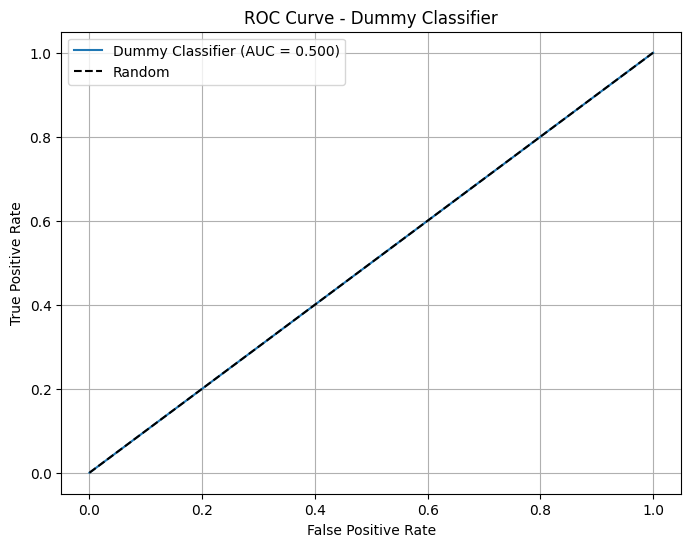

In [15]:
# Initialize the dummy classifier with most_frequent strategy
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)

# Fit the model
dummy_clf.fit(features_train, target_train)

# Get probability predictions
dummy_probs = dummy_clf.predict_proba(features_train)[:, 1]

# Calculate ROC curve points
fpr, tpr, _ = roc_curve(target_train, dummy_probs)

# Calculate AUC score
dummy_score = roc_auc_score(target_train, dummy_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Dummy Classifier (AUC = {dummy_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Dummy Classifier')
plt.legend()
plt.grid(True)
plt.show()

This gives us our baseline for model performance. All models should have a ROC curve with sigificant area above the dummy model curve to prove it is better than just guessing the most frequent value ("1" for active customers).

### Logistic Regression

In [16]:
#Train LogisticRegression
model = LogisticRegression()
model = model.fit(features_train, target_train)
predictions_train = model.predict_proba(features_train)[:, 1]
predictions_valid = model.predict_proba(features_valid)[:, 1]
score_train = roc_auc_score(target_train, predictions_train)
score_valid = roc_auc_score(target_valid, predictions_valid)
print(f'AUC-ROC score for Logistic Regression on Training Set: {score_train}')
print(f'AUC-ROC score for Logistic Regression on Validation Set: {score_valid}')

AUC-ROC score for Logistic Regression on Training Set: 0.8427398258449181
AUC-ROC score for Logistic Regression on Validation Set: 0.8419331699757058


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Already good results on training and validation, but let's continue for better.

### Random Forest

In [17]:
#Testing various parameters for RF
param_grid = {
    'n_estimators': [100,200],
    'max_depth': [6,9]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc'
)

grid_search.fit(features_train, target_train)
print("Best parameters:", grid_search.best_params_)
print("Best ROC AUC score for Training Set:", grid_search.best_score_)
best_rf = grid_search.best_estimator_
valid_probs = best_rf.predict_proba(features_valid)[:, 1]
valid_score = roc_auc_score(target_valid, valid_probs)
print(f"Validation ROC AUC: {valid_score}")

Best parameters: {'max_depth': 9, 'n_estimators': 200}
Best ROC AUC score for Training Set: 0.8761587490807811
Validation ROC AUC: 0.8821547499371702


We meet our threshold for success and this model can move to testing. Let's continue with other models.

### LightGBM

In [18]:
#Test LightGBM paramters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
lgbm = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc'
)

grid_search.fit(features_train, target_train)
print("Best parameters:", grid_search.best_params_)
print("Best ROC AUC score:", grid_search.best_score_)
best_lgbm = grid_search.best_estimator_
valid_probs = best_lgbm.predict_proba(features_valid)[:, 1]
valid_score = roc_auc_score(target_valid, valid_probs)
print(f"Validation ROC AUC: {valid_score}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best ROC AUC score: 0.9097522083481195
Validation ROC AUC: 0.925345040629974


This model also performs well and can move to testing.

### KNN Classifier

In [19]:
#Test KNN parameters
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc'
)
grid_search.fit(features_train, target_train)
print("Best parameters:", grid_search.best_params_)
print("Best ROC AUC score:", grid_search.best_score_)
best_knn = grid_search.best_estimator_
valid_probs = best_knn.predict_proba(features_valid)[:, 1]
valid_score = roc_auc_score(target_valid, valid_probs)
print(f"Validation ROC AUC: {valid_score}")

Best parameters: {'n_neighbors': 7, 'weights': 'distance'}
Best ROC AUC score: 0.8020484984835476
Validation ROC AUC: 0.7971786776409483


KNN is not quite good enough for us here.

## Testing and ROC Curves

### Random Forest Testing and ROC Curve

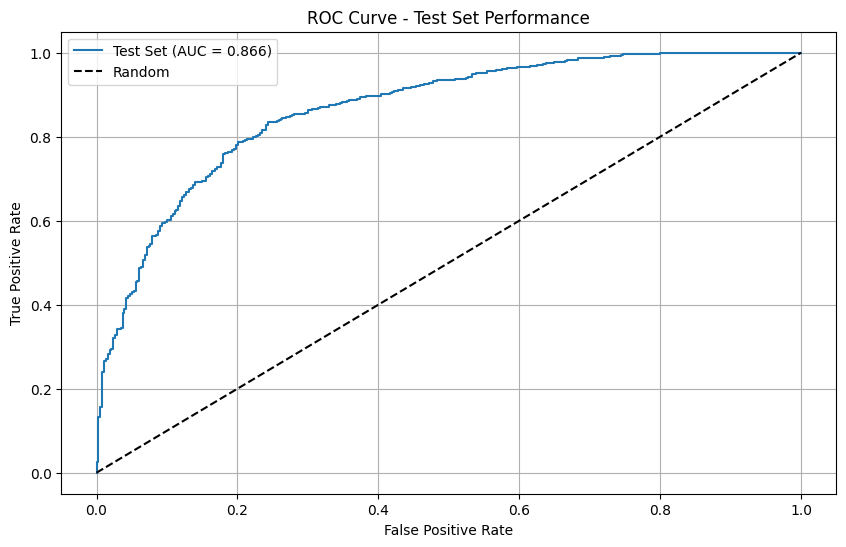

In [20]:
# Get probability predictions on test set
test_probs = best_rf.predict_proba(features_test)[:, 1]

# Calculate ROC curve points
test_fpr, test_tpr, _ = roc_curve(target_test, test_probs)

# Calculate AUC score
test_auc = roc_auc_score(target_test, test_probs)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(test_fpr, test_tpr, label=f'Test Set (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set Performance')
plt.legend()
plt.grid(True)
plt.show()

Our best Random Forest model significantly outperforms the dummy model and does not have a steep drop off in testing.

__Final AUC-ROC: 0.866__

### LightGBM Testing and ROC Curve

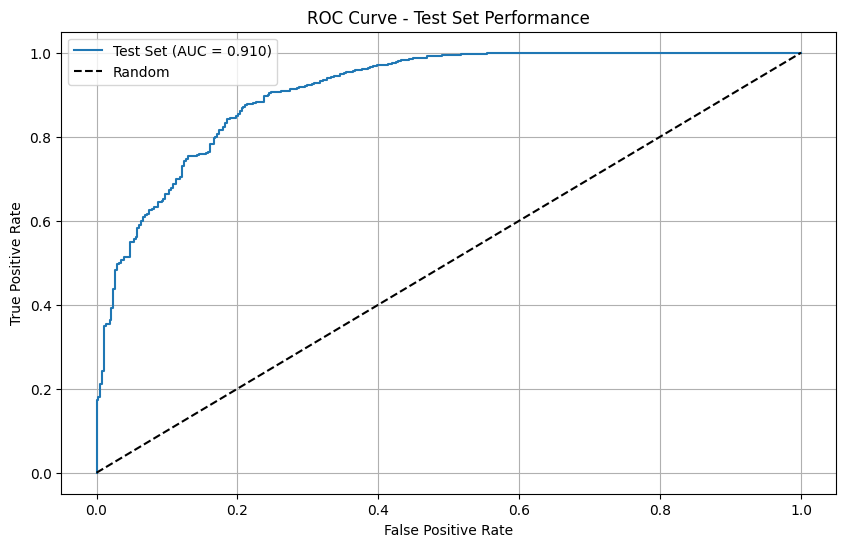

In [21]:
# Get probability predictions on test set
test_probs = best_lgbm.predict_proba(features_test)[:, 1]

# Calculate ROC curve points
test_fpr, test_tpr, _ = roc_curve(target_test, test_probs)

# Calculate AUC score
test_auc = roc_auc_score(target_test, test_probs)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(test_fpr, test_tpr, label=f'Test Set (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set Performance')
plt.legend()
plt.grid(True)
plt.show()

This model massively outperforms the dummy model and maintains performance in the testing set.

__Final AUC-ROC: 0.91__

__We have found our best model to be the LightGBM model.__

**Best Parameters: learning_rate: 0.1, max_depth: 5, n_estimators: 200**

# Conclusion

We were tasked with creating a model to predict customer churn based on four sets of customer data.

We performed the following steps to achieve our objective:

* Performed preprocessing of data to prepare for model creation.

* Tested various models and hyperparameters to find the best model.

* Identified our best model with a AUC-ROC score of 0.91.

* Verified the performance of our best model against the benchmark dummy model in training, validation, and testing.

* Verified the sturdiness of our model by graphing the ROC curve against the dummy model. 

* Identified our final best model as our LightGBM model.

It is clear that we achieved our objective and created a robust model to predict customer churn.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

You did a great job! Everything is correct. Well done! Based on your roc-auc score you achieved 6.0/6.0 sp. To be honest, not a many students can achieve such a high score:)
    
Good luck with your new job search!

</div>